In [99]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings
warnings.filterwarnings("ignore")
aapl = yf.download("AAPL", start='2020-01-01')
close = aapl['Adj Close']
pct = close.pct_change()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# from 100 to 300, using data from 0 to 300
prediction_n = 200
predictions = np.zeros(prediction_n)
for day in range(prediction_n):
    print(day)
    series = pct.iloc[day:day+prediction_n]
    model = sm.tsa.arima.ARIMA(series, order=(5, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
    model_fit = model.fit()
    prediction = model_fit.forecast().iloc[0]
    predictions[day] = prediction

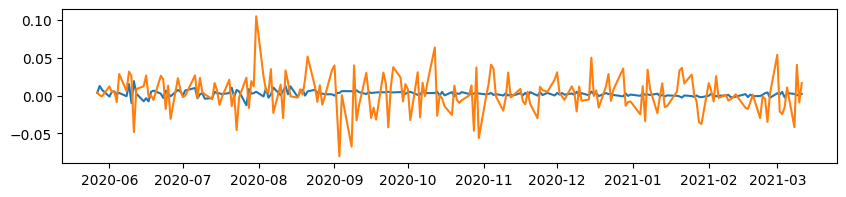

In [149]:
plt.figure(figsize=(10, 2))
plt.plot(pd.Series(predictions, index=pct.iloc[100:100+prediction_n].index))
plt.plot(pct.iloc[100:100+prediction_n])
plt.show()

In [159]:
def get_winrate(df, col='fit', benchmark = 'sensor'):
    return (len(df[(df[col] > 0) & (df[benchmark] > 0)]) + len(df[(df[col] < 0) & (df[benchmark] < 0)]))/len(df)
    
df_final = pd.DataFrame({'measurement': predictions[-100:]}, index=pct.iloc[200:300].index)
df_final['sensor'] = pct.iloc[200:300]
# prediction: index對標想要預測的日期，actual_pct不用調整
vars = pct.iloc[100:100+prediction_n].rolling(window=100).var().dropna()
vars_prediction = pd.Series(predictions, index=pct.iloc[100:300].index).rolling(window=100).var().dropna()
df_final['var_sensor'] = vars
df_final['var_measurement'] = vars_prediction[1:]

In [161]:
df_final['kalman ratio'] = df_final['var_sensor']/(df_final['var_sensor']+df_final['var_measurement'].shift(-1))
df_final['new_measurement'] = df_final['kalman ratio'] * df_final['measurement']

print("origin winrate:", get_winrate(df_final, col='measurement'))
print("new winrate:", get_winrate(df_final, col='new_measurement'))

origin winrate: 0.47
new winrate: 0.46


(-10.591397213204502,
 6.513906781289785e-19,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 -427.9063310674967)

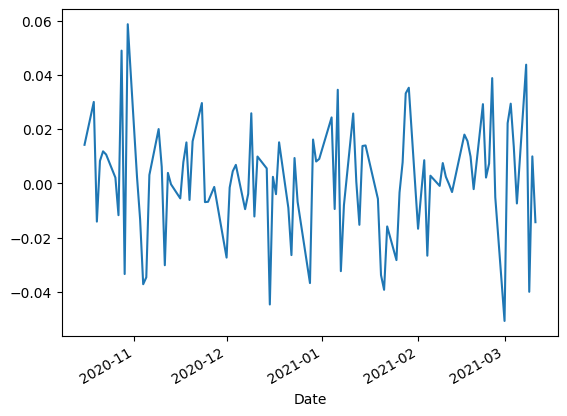

In [164]:
(df_final['measurement'] - df_final['sensor']).plot()
from statsmodels.tsa.stattools import adfuller
adfuller((df_final['measurement'] - df_final['sensor']))

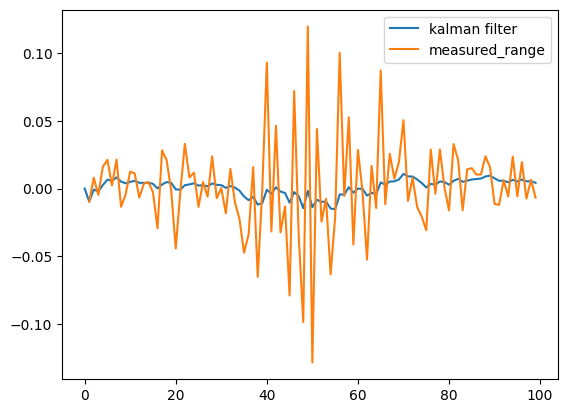

In [70]:
x = np.zeros(num_measurement)
p = np.zeros(num_measurement)
p_vars = np.zeros(num_measurement)
kalman_gain = np.zeros(num_measurement)
R = 0.01 # measurement covariance
c = 0.0001 # process covariance
x[0] = 0
p[0] = 1 # error covariance

for i in range(1, num_measurement):

    p_var = p[i-1] + c
    p_vars[i] = p_var
    kalman_gain[i] = p_var/(p_var + R) # hwdge ratio to be honest, if R, c are time variant => hedge ratio would also be time variant
    x[i] = (1 - kalman_gain[i]) * x[i-1] + kalman_gain[i] * measured_range[i] # x[i] is for x[i+1] time period
    p[i] = (1 - kalman_gain[i]) * p_var
plt.plot(x, label='kalman filter')
plt.plot(measured_range, label='measured_range')
plt.legend()
plt.show()

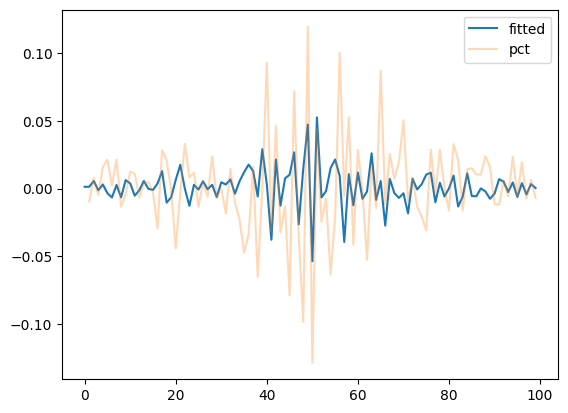

In [73]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(measured_range, order=(4, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
model_fit = model.fit()
model_fit.summary()
plt.plot(model_fit.fittedvalues, alpha=1, label='fitted')
plt.plot(measured_range, alpha=0.3, label='pct')
plt.legend()

In [179]:
prediction_n = 100
predictions = np.zeros(prediction_n)
pct = aapl['Close'].pct_change()
for day in range(prediction_n):
    series = pct.iloc[day:day+prediction_n]
    model = sm.tsa.arima.ARIMA(series, order=(5, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
    model_fit = model.fit()
    prediction = model_fit.forecast().iloc[0]
    predictions[day] = prediction

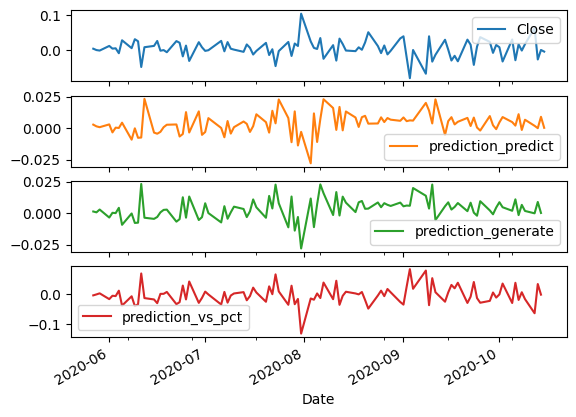

50


0.54

In [206]:
def get_winrate(df, col='fit', benchmark = 'sensor'):
    print(len(df))
    return (len(df[(df[col] > 0) & (df[benchmark] > 0)]) + len(df[(df[col] < 0) & (df[benchmark] < 0)]))/len(df)

pct = aapl[['Close']].pct_change().iloc[100:200]
pct['prediction_predict'] = predictions
pct['prediction_generate'] = pct['prediction_predict'].shift(-1)
pct['prediction_vs_pct'] = pct['prediction_generate'] - pct['Close']
pct.plot(subplots=True)


plt.show()
get_winrate(pct.iloc[-50:], col='prediction_predict', benchmark='Close')



In [204]:
prediction_n = 50
predictions_pct_diff = np.zeros(len(pct))
for day in range(prediction_n):
    series = pct['prediction_vs_pct'].iloc[day:day+prediction_n]
    model = sm.tsa.arima.ARIMA(series, order=(5, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
    model_fit = model.fit()
    prediction = model_fit.forecast().iloc[0]
    predictions_pct_diff[day+prediction_n] = prediction

In [205]:
pct['prediction_pct_diff'] = predictions_pct_diff
pct['new_prediction_plus_prediction_pct_diff'] = pct['prediction_predict'] - pct['prediction_pct_diff']
get_winrate(pct.iloc[-50:], col='new_prediction_plus_prediction_pct_diff', benchmark='Close')

50


0.56